<a href="https://colab.research.google.com/github/sahiliem/colab/blob/main/Deep_Learning_With_PyTorch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

---

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [107]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor,Lambda

In [108]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Here is an example of how to load the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
root is the path where the train/test data is stored,

train specifies training or test dataset,

download=True downloads the data from the internet if it’s not available at root.

transform and target_transform specify the feature and label transformations

In [109]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [110]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

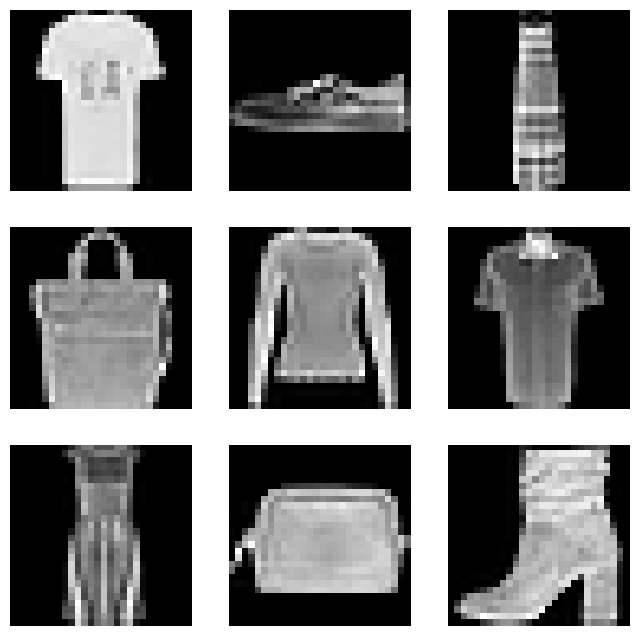

In [111]:
# Let display the images
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    #plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Define the Class
---
We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [112]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of NeuralNetwork, and move it to the device, and print its structure.

In [113]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model’s forward, along with some background operations. Do not call model.forward() directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0 corresponding to each output of 10 raw predicted values for each class, and dim=1 corresponding to the individual values of each output. We get the prediction probabilities by passing it through an instance of the nn.Softmax module.

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

---
Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters (as we saw in the previous section), and optimizes these parameters using gradient descent

**Hyperparameters**
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:
Number of Epochs - the number times to iterate over the dataset

Batch Size - the number of data samples propagated through the network before the parameters are updated

Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [114]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

**Optimization Loop**
Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

Let’s briefly familiarize ourselves with some of the concepts used in the training loop

In [115]:
# Train

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")




In [116]:
# Test
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [117]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308375  [   64/60000]
loss: 2.298712  [ 6464/60000]
loss: 2.284243  [12864/60000]
loss: 2.276564  [19264/60000]
loss: 2.271016  [25664/60000]
loss: 2.234325  [32064/60000]
loss: 2.244454  [38464/60000]
loss: 2.211279  [44864/60000]
loss: 2.211843  [51264/60000]
loss: 2.187551  [57664/60000]
Test Error: 
 Accuracy: 41.6%, Avg loss: 2.184276 

Epoch 2
-------------------------------
loss: 2.192760  [   64/60000]
loss: 2.183892  [ 6464/60000]
loss: 2.137289  [12864/60000]
loss: 2.151333  [19264/60000]
loss: 2.114314  [25664/60000]
loss: 2.048681  [32064/60000]
loss: 2.079641  [38464/60000]
loss: 2.003082  [44864/60000]
loss: 2.014524  [51264/60000]
loss: 1.952146  [57664/60000]
Test Error: 
 Accuracy: 52.9%, Avg loss: 1.948106 

Epoch 3
-------------------------------
loss: 1.975939  [   64/60000]
loss: 1.944305  [ 6464/60000]
loss: 1.842577  [12864/60000]
loss: 1.887035  [19264/60000]
loss: 1.783527  [25664/60000]
loss: 1.720466  [32064/600

In [118]:
# Save the Model
import torchvision.models as models

Saving and Loading Model Weights
PyTorch models store the learned parameters in an internal state dictionary, called state_dict. These can be persisted via the torch.save method:

In [119]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]
